# TODO

1. Trovare un modo per valutare la distanza tra i break points trovati e quelli originali XXX
2. Effettuare valutazione su differenti testi
3. Utilizzare una versione più grande di glove
4. Refactoring codice XXX + commenti 
5. Scrittura  markdown 

In [ ]:
from pathlib import Path
import nltk
import numpy as np

import src.data_manager as dm
import src.text_segmentation as segm
import src.viz as viz

import matplotlib.pyplot as plt

plt.style.use('seaborn')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Documents eda

* quali documenti, da dove sono stati presi?
* struttura Document, e assunzione fondamentale che i true breakpoints sono i paragrafi
(attenzione questo non è da dare per sconteto (vedi paper text tiling) in quanto a volte le persone dividono in paragrafi pù per una questione estetica che strutturale-semantica)


In [ ]:
doc = dm.Document(Path('data/associative_memory.txt'), nltk.sent_tokenize)

### Glove embedding
* what is glove?
* perchè glove?
* glove vs word2vec vs tf-idf



In [ ]:
glove_path = Path("data/glove/glove.6B.100d.txt")
glove = dm.Glove(glove_path)

### Text segmentation

* spiegare task
* spiegare approccio (simil text tiling https://www.aclweb.org/anthology/J97-1003.pdf)
* possibili drawbacks e assunzioni fatte

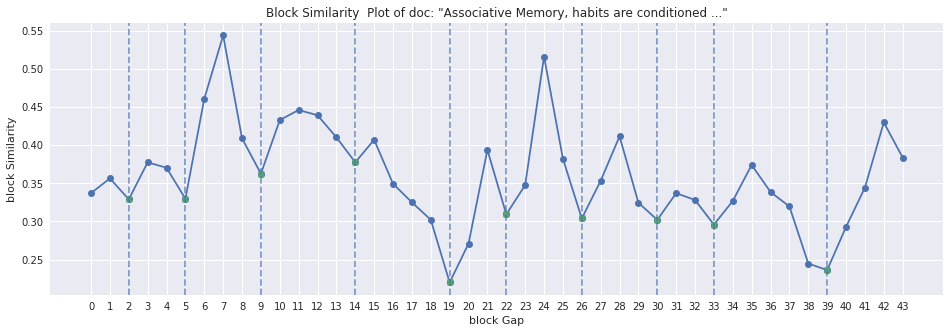

In [ ]:
segmenter = segm.TextSegmenter(segm.preprocessor, glove, segm.cosine_similarity)

minima, similarities, blocks = segmenter.segment(doc, initial_blocks=45)


fig, ax = plt.subplots(1,1,figsize=(16,5))
viz.block_similarity_plot(ax, doc, minima, similarities)

### TODO 
spiegare l'utilità della funzione valley_to blocks e i due livelli di lavoro chunks-blocks

In [ ]:
def valleys_to_breakpoints(valleys, blocks):
    chunks = []

    # from first block to the first break point
    [chunks.extend(block) for block in blocks[0:valleys[0]+1]]
    chunks.append(dm.Document.BLOCK_SEPARATOR)

    for start, end in zip(valleys[0::], valleys[1::]):
        for block in blocks[start+1:end+1]:
            chunks.extend(block)
        chunks.append(dm.Document.BLOCK_SEPARATOR)

    # from last breakpoint to the last block
    [chunks.extend(block) for block in blocks[valleys[-1]+1:]]

    # Search only for breakpoints
    sep_pos = [i for i,chunk in enumerate(chunks) 
                   if chunk == dm.Document.BLOCK_SEPARATOR]
        
    breakpoints_pos = [(pos-1, pos) for pos in sep_pos] # we must take into account that pos when BLOCK_SEPARATOR is removed, is the right index of the next sentence (not pos+1)

    return breakpoints_pos, chunks

In [ ]:
valleys, sims, blocks = segmenter.segment(doc, initial_blocks=40)

breakpoints, system_chunks = valleys_to_breakpoints(valleys, blocks)

true_breakpoints = np.array([breakpoint[0] for breakpoint in doc.get_breakpoints()])
system_breakpoints = np.array([breakpoint[0] for breakpoint in breakpoints])

### Evaluation

In [ ]:
if len(true_breakpoints) == len(system_breakpoints):
    diff = np.abs(true_breakpoints-system_breakpoints)
    print(f"Avg offset error {diff.mean()}+-{diff.std():.2f}, with min {diff.min()} and max {diff.max()}")

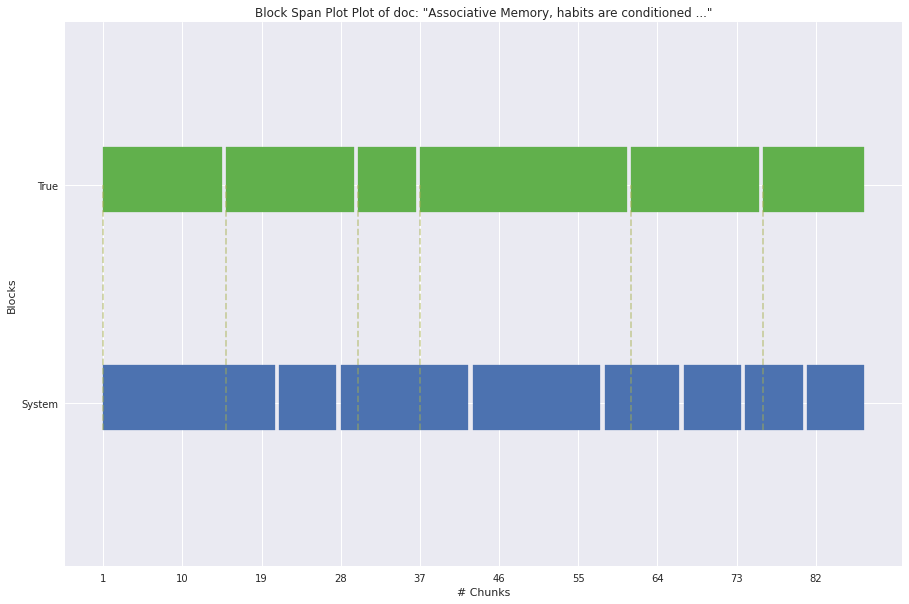

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
viz.block_span_plot(ax, doc, true_breakpoints, system_breakpoints)

### Batch evaluation

TODO eseguire su tutti i testi la pipeline precedente e trovare un modo per sommarizzare i risultati ottentuti

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=afb22156-bb61-4d65-847d-18db79c0d4d2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>